# Square-root EnKF with Lorenz 63 Model

## Imports

In [35]:
import numpy as np
import time
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import lorenz63_model as lor

## Initialization of Variables

In [36]:
assim_len = 1.0
fcst_len  = 2.0
nassim    = 200
Nens = 10
inflate = 1.1

## Main Code

####   Code for running square-root EnKF with the Lorenz 63 model.
Developed by Aneesh Subramanian, Ryan Torn and Greg Hakim.

In [37]:
H = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])  #  observation operator
#H = np.array([[1., 0., 0. ]]) #  observation operator for single observation
nobs = len(H[:,0])
R = np.eye(3) * 1.0e-2  #  observation error
#R = np.array([[1.0e-2]])  #  observation error for single observation

In [38]:
time1 = time.time()

np.random.seed(0)

fac = 1.0 / float(Nens-1)

In [39]:

# Initialize lists for storing errors
analysis_error_list = []
forecast_error_list = []


### IC for truth taken from last time (column vector):
# Calculate and store errors
analysis_error = np.linalg.norm(xaerr[t, :])
forecast_error = np.linalg.norm(xferr[t, :])

analysis_error_list.append(analysis_error)
forecast_error_list.append(forecast_error)


In [40]:
xt = np.array(lor.advance(10., 20., 30., 100.))
xt

array([ 1.29649403,  2.1041806 , 13.1900553 ])

###  Create initial ensemble analysis and background arrays, add noise to analysis

In [41]:
xbens = np.empty((3,Nens))
xaens = np.empty((3,Nens))

for n in range(Nens):
  xaens[:,n] = xt[:]
xaens[:,:] = xaens[:,:] + np.random.normal(0,0.1,xaens.shape)
xaens

array([[ 1.47289926,  1.33650975,  1.39436783,  1.52058335,  1.48324983,
         1.19876624,  1.39150287,  1.28135831,  1.28617214,  1.33755388],
       [ 2.11858495,  2.24960795,  2.18028437,  2.1163481 ,  2.14856692,
         2.13754803,  2.2535885 ,  2.08366477,  2.13548737,  2.01877102],
       [12.93475632, 13.25541716, 13.27649892, 13.11583879, 13.41703076,
        13.04461873, 13.19463115, 13.17133691, 13.34333322, 13.33699117]])

###  Create arrays related to ensemble mean, and K matrix

In [42]:
xam = np.empty(3)
xbm = np.empty(3)
xf  = np.empty(3)
xe  = np.empty(3)

###  Create error matricies

In [43]:
xaerr = np.empty((nassim, 3))
xberr = np.empty((nassim, 3))
xferr = np.empty((nassim, 3))

###  Create data assimilation matricies

In [44]:
innov   = np.empty(nobs)
yobs    = np.empty(nobs)
Hxa     = np.empty(Nens)
K       = np.empty(3)

for t in range(nassim):

  #  Advance the truth, compute observations
  xt[0], xt[1], xt[2] = lor.advance(xt[0], xt[1], xt[2], assim_len)
  yobs[:] = np.matmul(H,xt) + np.random.normal(0, np.diag(np.sqrt(R)), nobs)

  #  Advance each ensemble member to the next assimilation time, compute mean
  for n in range(Nens):
    xbens[0,n], xbens[1,n], xbens[2,n] = lor.advance(xaens[0,n], xaens[1,n], xaens[2,n], assim_len)

  xbm[:] = np.mean(xbens, axis=1)

  #  Prepare to assimilation observations, remove mean, inflate perturbations
  xaens[:,:] = xbens[:,:]
  xam[:] = xbm[:]

  for n in range(Nens):
    xaens[:,n] = (xaens[:,n] - xam[:]) * inflate

  for o in range(nobs):

    #  Evaluate each ensemble member's observation estimate
    for n in range(Nens):
      Hxa[n] = np.matmul(H[o,:],(xaens[:,n]+xam[:]))

    #  Compute ensemble mean observation estimate, innovation, remove mean
    hx = np.mean(Hxa)
    innov = yobs[o] - hx
    Hxa[:]= Hxa[:] - hx

    #  compute K, update the ensemble mean
    Kden   = fac * np.matmul(Hxa,np.transpose(Hxa)) + R[o,o]
    K      = (fac/Kden) * np.matmul(xaens,np.transpose(Hxa))
    xam[:] = xam[:] + K[:] * innov

    # update perturbations using modified gain
    beta= ( 1.0 + np.sqrt( R[o,o] / Kden ) )**-1

    for i in range(3):
      xaens[i,:] = xaens[i,:] - beta * K[i] * Hxa[:]

  print('analyzed values:', xam)
  print('verification   :', xt)

  #  Add mean back into the ensemble members
  for n in range(Nens):
    xaens[:,n] = xaens[:,n] + xam[:]

  xberr[t,:] = xbm[:] - xt[:]
  xaerr[t,:] = xam[:] - xt[:]

  # compute forecast and error
  xf[0], xf[1], xf[2] = lor.advance(xam[0], xam[1], xam[2], fcst_len)
  xe[0], xe[1], xe[2] = lor.advance(xt[0], xt[1], xt[2], fcst_len)

  xferr[t,:] = xf[:] - xe[:]
  # Calculate and store errors
  analysis_error = np.linalg.norm(xaerr[t, :])
  forecast_error = np.linalg.norm(xferr[t, :])

  analysis_error_list.append(analysis_error)
  forecast_error_list.append(forecast_error)


    
    
#   # Calculate the analysis error based on the provided formula
#   analysis_error = np.sqrt(sum(sum(xaerr[:] * xaerr[:])) / float(nassim * 3))
#   # Store the analysis error in a list if you want to track its evolution
#   analysis_error_list.append(analysis_error)


print('Analysis Error: ',np.sqrt(sum(sum(xaerr[:] * xaerr[:])) / float(nassim*3)))
print('Background Error: ',np.sqrt(sum(sum(xberr[:] * xberr[:])) / float(nassim*3)))
print('Forecast Error: ',np.sqrt(sum(sum(xferr * xferr)) / float(nassim*3)))

time2 = time.time()

print("Total Time:",time2-time1)

analyzed values: [-12.24124313 -17.11518736  25.66058077]
verification   : [-12.25828404 -17.1005161   25.74326122]
analyzed values: [-4.82096499  1.74161601 30.90895961]
verification   : [-4.75224989  1.7572222  30.81942639]
analyzed values: [-1.51029165 -2.75913094 18.25610991]
verification   : [-1.55414176 -2.82473629 18.30596769]
analyzed values: [-0.14960787 -0.27345379  8.93743132]
verification   : [-0.10108081 -0.18343227  8.92696459]
analyzed values: [ 7.68764221 10.30355593 22.56601477]
verification   : [ 7.66256096 10.2412514  22.64309754]
analyzed values: [ 6.7316502   4.28474762 28.13649563]
verification   : [ 6.77137785  4.38730884 28.10069589]
analyzed values: [10.0713012  13.18916302 24.7269316 ]
verification   : [10.11001314 13.16463547 24.88599959]
analyzed values: [ 4.71489381  3.46630461 24.64827613]
verification   : [ 4.72882512  3.51318622 24.61132189]
analyzed values: [11.42342294 15.17501665 25.93524985]
verification   : [11.42879601 15.17526769 25.95187302]
anal

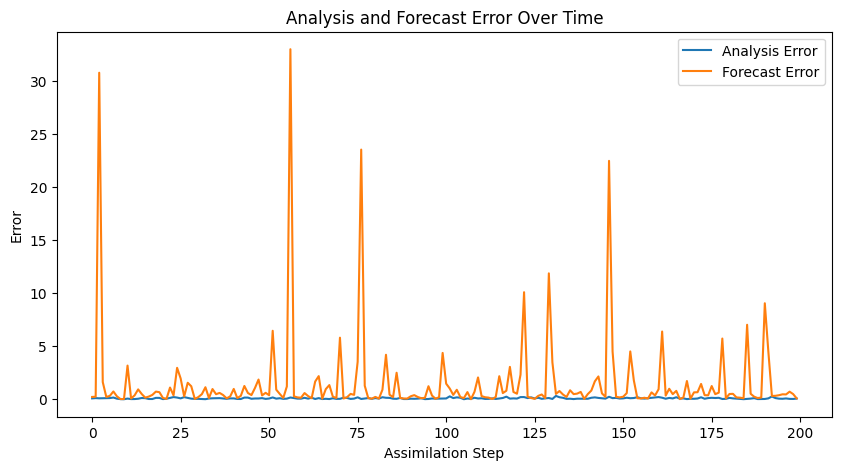

In [45]:

# Plot Errors
plt.figure(figsize=(10, 5))
plt.plot(analysis_error_list, label='Analysis Error')
plt.plot(forecast_error_list, label='Forecast Error')
plt.xlabel('Assimilation Step')
plt.ylabel('Error')
plt.title('Analysis and Forecast Error Over Time')
plt.legend()
plt.show()
